In [1]:
import numpy as np
import scipy
import librosa
import soundfile as sf
import librosa
from librosa.feature import melspectrogram
import sklearn
from sklearn import preprocessing
import pandas as pd
from uuid import uuid4
from tqdm import tqdm
import os

In [2]:
def log_melspectrogram(wave_data):
    mel = melspectrogram(y=wave_data, n_mels=216).T
    db = librosa.power_to_db(mel)
    normalised_db = preprocessing.minmax_scale(db)

    return normalised_db

def activity_detector(mel):
    energy = list()
    for mel_t in mel:
        energy.append(np.sum(np.square(mel_t)))

    scales = np.arange(1, 10)
    peaks = scipy.signal.find_peaks_cwt(energy, scales)
    peaks = sorted(peaks, key=lambda x: -energy[x])

    try:
        return (peaks[0] / len(energy), peaks[1] / len(energy))
    except:
        return

In [3]:
os.makedirs(os.getcwd() + "/data/birdclef-2023/processed", exist_ok=True)

In [4]:
data_df = pd.read_csv(os.getcwd() + "/data/birdclef-2023/train_audio/audio_paths.csv")
data_df.head()

,path,label
0,/Users/kimsan/Desktop/Lecture-Materials/3-1/AI...,ruegls1
1,/Users/kimsan/Desktop/Lecture-Materials/3-1/AI...,ruegls1
2,/Users/kimsan/Desktop/Lecture-Materials/3-1/AI...,ruegls1
3,/Users/kimsan/Desktop/Lecture-Materials/3-1/AI...,ruegls1
4,/Users/kimsan/Desktop/Lecture-Materials/3-1/AI...,ruegls1


In [5]:
trimed_df = pd.DataFrame(columns=["path", "label"])

In [6]:
for index, row in tqdm(data_df.iterrows()):
    path = row["path"]
    label = row["label"]
    os.makedirs(os.getcwd() + "/data/birdclef-2023/processed/" + label, exist_ok=True)

    wave_data, sample_rate = librosa.load(path)
    
    mel = log_melspectrogram(wave_data)

    try:
        peak1, peak2 = activity_detector(mel)
    except:
        continue

    center1 = int(len(wave_data) * peak1)
    center2 = int(len(wave_data) * peak2)

    if (center1 - 2 * sample_rate < 0):
        trim_data1 = wave_data[:center1 + 2*sample_rate]
        trim_data1 = np.append([0 for i in range(abs(center1 - 2 * sample_rate))], trim_data1)

    elif (center1 + 2 * sample_rate >= len(wave_data)):
        trim_data1 = wave_data[center1 - 2*sample_rate:]
        trim_data1 = np.append(trim_data1, [0 for i in range(center1 + 2 * sample_rate - len(wave_data))])

    else:
        trim_data1 = wave_data[center1 - 2*sample_rate: center1 + 2*sample_rate]

    if (center2 - 2 * sample_rate < 0):
        trim_data2 = wave_data[: center2 + 2*sample_rate]
        trim_data2 = np.append([0 for i in range(abs(center2 - 2 * sample_rate))], trim_data2)

    elif (center2 + 2 * sample_rate >= len(wave_data)):
        trim_data2 = wave_data[center2 - 2*sample_rate:]
        trim_data2 = np.append(trim_data2, [0 for i in range(center2 + 2 * sample_rate - len(wave_data))])

    else:
        trim_data2 = wave_data[center2 - 2*sample_rate: center2 + 2*sample_rate]

    filename1 = str(uuid4()) + ".ogg"
    filename2 = str(uuid4()) + ".ogg"

    sf.write("data/birdclef-2023/processed/" + label + "/" + filename1, trim_data1, samplerate=sample_rate)
    sf.write("data/birdclef-2023/processed/" + label + "/" + filename2, trim_data2, samplerate=sample_rate)

    trimed_df.loc[len(trimed_df)] = ["data/birdclef-2023/processed/" + label + "/" + filename1, label]
    trimed_df.loc[len(trimed_df)] = ["data/birdclef-2023/processed/" + label + "/" + filename2, label]

2103it [07:09,  1.06s/it]/Users/kimsan/Desktop/Lecture-Materials/3-1/AIGS538-Deep-Learning/final-project/dl-final-project/lib/python3.10/site-packages/scipy/signal/_peak_finding.py:1192: RuntimeWarning: invalid value encountered in scalar divide
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
3220it [11:41,  2.55it/s]/Users/kimsan/Desktop/Lecture-Materials/3-1/AIGS538-Deep-Learning/final-project/dl-final-project/lib/python3.10/site-packages/scipy/signal/_peak_finding.py:1192: RuntimeWarning: divide by zero encountered in scalar divide
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
5185it [21:53,  7.62it/s]/Users/kimsan/Desktop/Lecture-Materials/3-1/AIGS538-Deep-Learning/final-project/dl-final-project/lib/python3.10/site-packages/scipy/signal/_peak_finding.py:1192: RuntimeWarning: invalid value encountered in scalar divide
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])
8989it [41:16,  6.26it/s]/Users/kimsan/Desktop/Lecture-Materials/3-1/AIGS53

In [16]:
trimed_df.to_csv("data/birdclef-2023/processed/trimed_df.csv", index=False)


ValueError: hist method requires numerical or datetime columns, nothing to plot.

In [19]:
one_hot_encodings = {label: index for index, label in enumerate(sorted(list(set(trimed_df["label"]))))}

trimed_df["numeric_label"] = pd.Series([one_hot_encodings[row["label"]] for index, row in trimed_df.iterrows()])

array([[<Axes: title={'center': 'numeric_label'}>]], dtype=object)

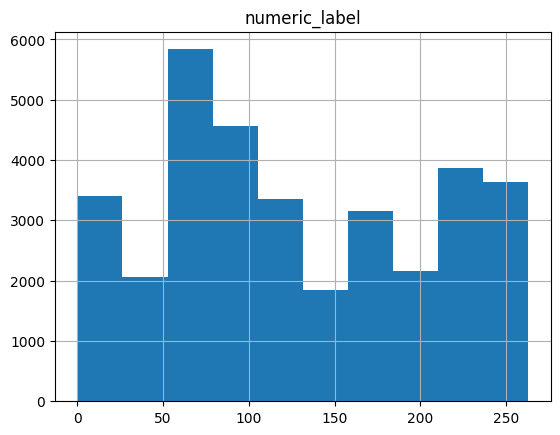

In [21]:
trimed_df.hist(column="numeric_label")

In [22]:
# Sanity check
for index, row in trimed_df.iterrows():
    wave_data, sample_rate = librosa.load(row["path"])
    if (len(wave_data) != 88200): trimed_df.drop(index, axis=0, inplace=True)



array([[<Axes: title={'center': 'numeric_label'}>]], dtype=object)

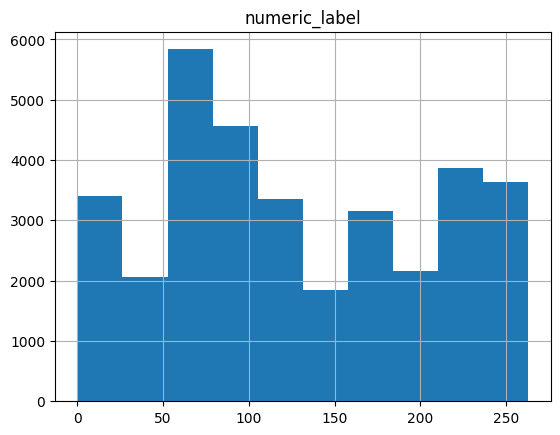

In [23]:
trimed_df.hist(column="numeric_label")